## Heart Disease Prediction using Machine Learning with ensemble

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
# for model improvement
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from scipy.interpolate import interp1d
import joblib
import warnings
warnings.filterwarnings('ignore')

### Data Collection and Processing

In [2]:
# loading data into pandas data frame

heart_data = pd.read_csv("./heart.csv")
heart_data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
# Display data types and non-null counts
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [4]:
# Display basic statistical summary
heart_data.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
# Check if there are any categorical features before describing them
if heart_data.select_dtypes(include=['object']).empty:
    print("No categorical features found.")
else:
    # Summary statistics for categorical features
    print(heart_data.describe(include=[object]))

No categorical features found.


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


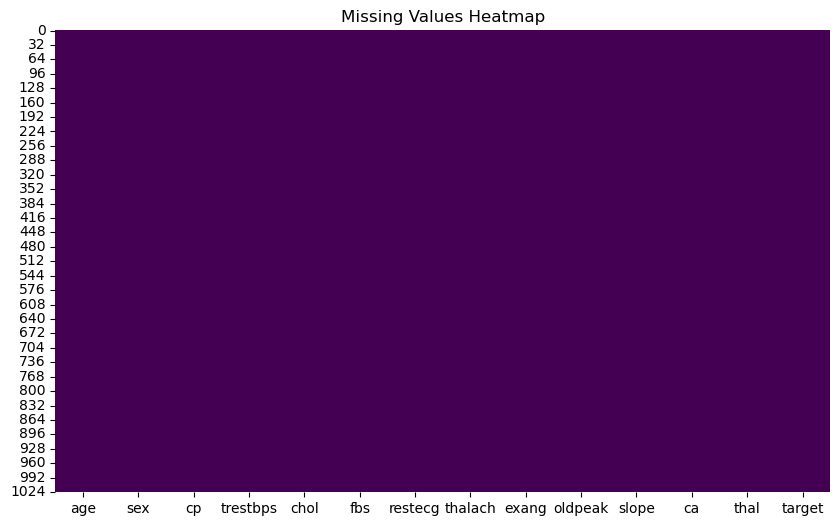

In [6]:
# Check for missing values
missing_values = heart_data.isnull().sum()
print(missing_values)

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(heart_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [7]:
def plot_features(data, feature1, feature2, feature1_name, 
                  feature2_name, output_filename='output_plot.png', dpi=500):
    # Set IEEE style parameters
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'text.usetex': False,
        'font.size': 10,
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 8,
        'axes.linewidth': 1,
        'lines.linewidth': 1,
        'grid.linewidth': 0.5,
        'legend.frameon': True,
        'legend.loc': 'best',
        'grid.color': 'gray',  # Set grid color
        'grid.alpha': 0.5,     # Set grid transparency
        'axes.edgecolor': 'k',
        'axes.labelcolor': 'k',
        'xtick.color': 'k',
        'ytick.color': 'k',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.pad': 3,
        'ytick.major.pad': 3,
        'axes.labelpad': 4,
        'axes.formatter.use_mathtext': True
    })

    # Create subplots
    fig, axs = plt.subplots(3, 2, figsize=(7, 7))  # Adjust figure size as needed

    # Plot density histograms
    
    
    sns.histplot(data[feature1].dropna(), bins=20, kde=True, stat='density', color='b', ax=axs[0, 0])
    axs[0, 0].set_title(f'{feature1_name} Density')
    axs[0, 0].set_xlabel(feature1_name)
    axs[0, 0].set_ylabel('Density')
    axs[0, 0].grid(True)  # Enable grid

    sns.histplot(data[feature2].dropna(), bins=20, kde=True, stat='density', color='g', ax=axs[0, 1])
    axs[0, 1].set_title(f'{feature2_name} Density')
    axs[0, 1].set_xlabel(feature2_name)
    axs[0, 1].set_ylabel('Density')
    axs[0, 1].grid(True)  # Enable grid

    sns.histplot(data[feature1].dropna(), bins=20, kde=True, stat='probability', color='b', ax=axs[1, 0])
    axs[1, 0].set_title(f'{feature1_name} Probability')
    axs[1, 0].set_xlabel(feature1_name)
    axs[1, 0].set_ylabel('Probability')
    axs[1, 0].grid(True)  # Enable grid

    sns.histplot(data[feature2].dropna(), bins=20, kde=True, stat='probability', color='g', ax=axs[1, 1])
    axs[1, 1].set_title(f'{feature2_name} Probability')
    axs[1, 1].set_xlabel(feature2_name)
    axs[1, 1].set_ylabel('Probability')
    axs[1, 1].grid(True)  # Enable grid
    
    sns.histplot(data[feature1].dropna(), bins=20, kde=True, color='b', ax=axs[2, 0])
    axs[2, 0].set_title(f'{feature1_name} Frequency')
    axs[2, 0].set_xlabel(feature1_name)
    axs[2, 0].set_ylabel('Frequency')
    axs[2, 0].grid(True)  # Enable grid

    sns.histplot(data[feature2].dropna(), bins=20, kde=True, color='g', ax=axs[2, 1])
    axs[2, 1].set_title(f'{feature2_name} Frequency')
    axs[2, 1].set_xlabel(feature2_name)
    axs[2, 1].set_ylabel('Frequency')
    axs[2, 1].grid(True)  # Enable grid


    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(output_filename, dpi=dpi)  # Use high dpi for better resolution
    plt.show()

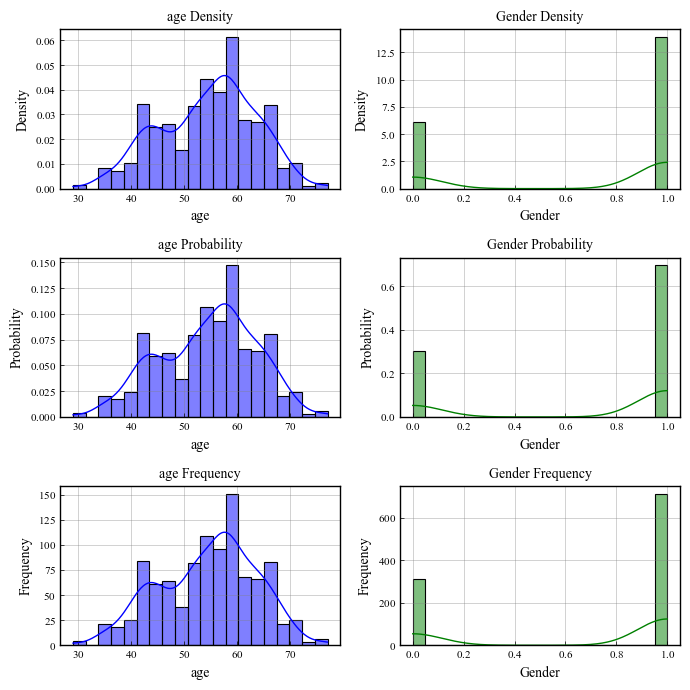

In [8]:
# Plot features
plot_features(heart_data, 'age', 'sex','age','Gender', output_filename='histogramOfAgeSex.png', dpi=500)

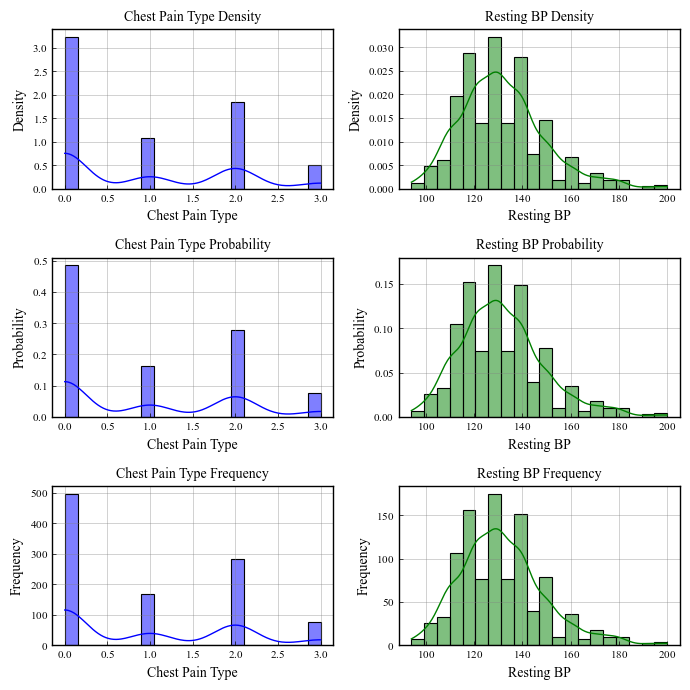

In [9]:
# Plot features
plot_features(heart_data, 'cp', 'trestbps','Chest Pain Type','Resting BP', output_filename='histogramOfCpTrestbps.png', dpi=500)

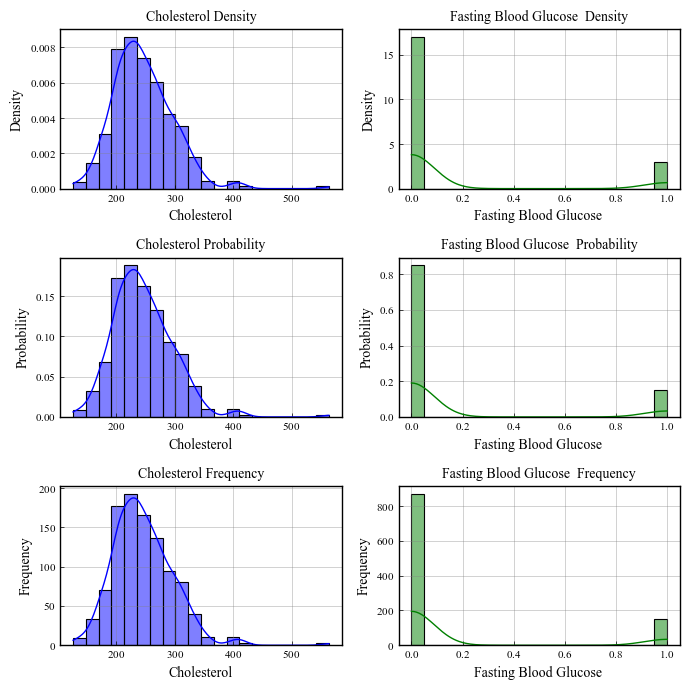

In [10]:
# Plot features
plot_features(heart_data, 'chol', 'fbs','Cholesterol','Fasting Blood Glucose ', output_filename='histogramOfCholFbs.png', dpi=500)

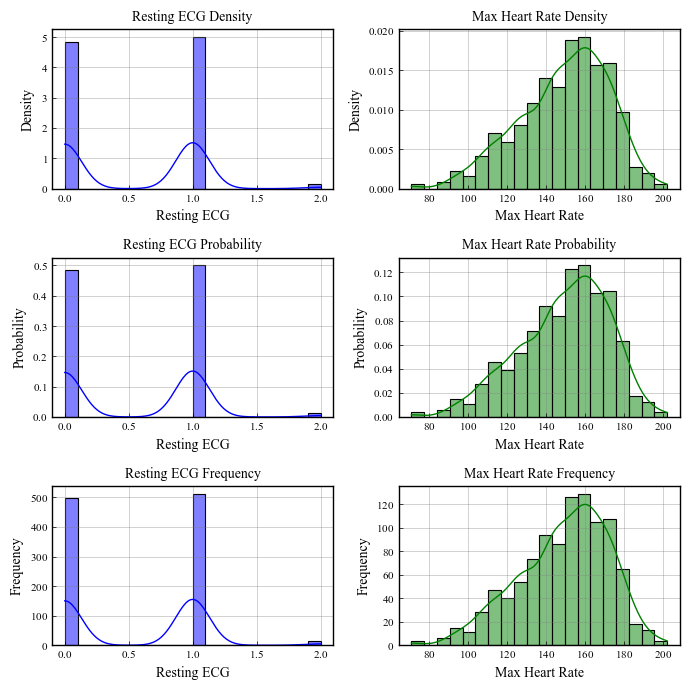

In [11]:
# Plot features
plot_features(heart_data, 'restecg', 'thalach','Resting ECG','Max Heart Rate', output_filename='histogramOfRestEcgThalach.png', dpi=500)

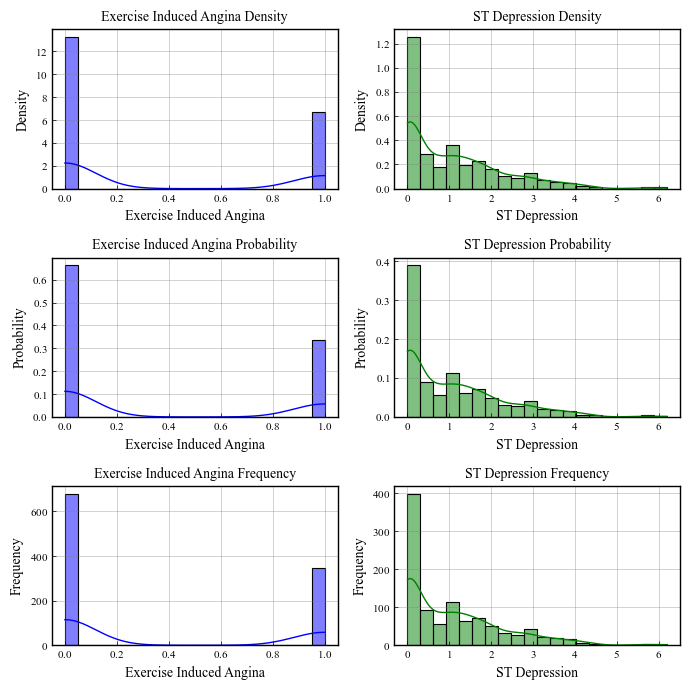

In [12]:
# Plot features
plot_features(heart_data, 'exang', 'oldpeak','Exercise Induced Angina','ST Depression', output_filename='histogramOfExangOldpeak.png', dpi=500)

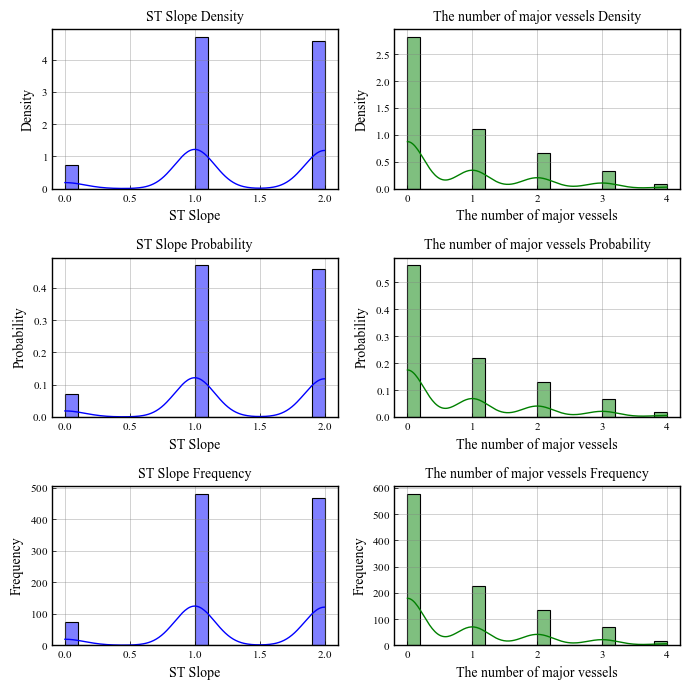

In [13]:
# Plot features
plot_features(heart_data, 'slope', 'ca','ST Slope','The number of major vessels', output_filename='histogramOfSlopeCa.png', dpi=500)

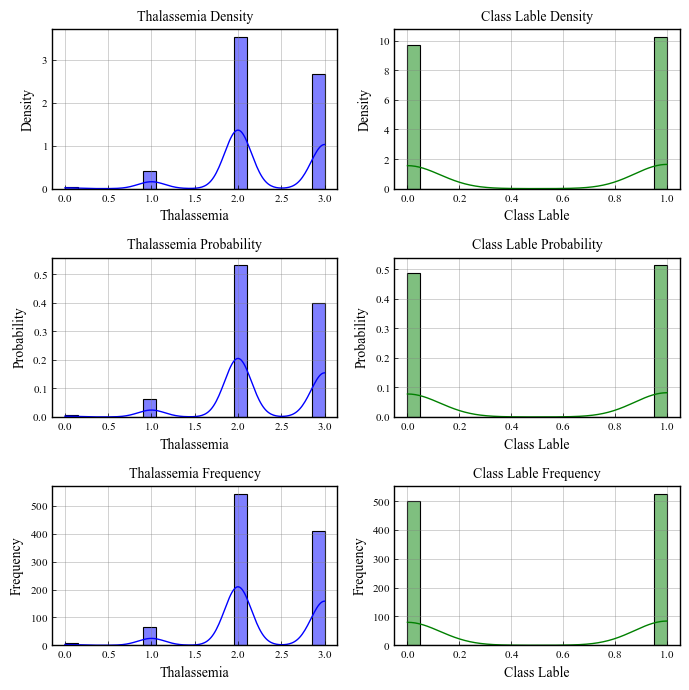

In [14]:
# Plot features
plot_features(heart_data, 'thal', 'target','Thalassemia','Class Lable', output_filename='histogramOfThalTarget.png', dpi=500)

In [15]:
# Count plots for categorical features
categorical_features = heart_data.select_dtypes(include=['object']).columns

if not categorical_features.empty:
    plt.figure(figsize=(14, 10))
    for i, col in enumerate(categorical_features, 1):
        plt.subplot(2, 3, i)
        sns.countplot(y=col, data=df)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
else:
    print("No categorical features to plot.")

No categorical features to plot.


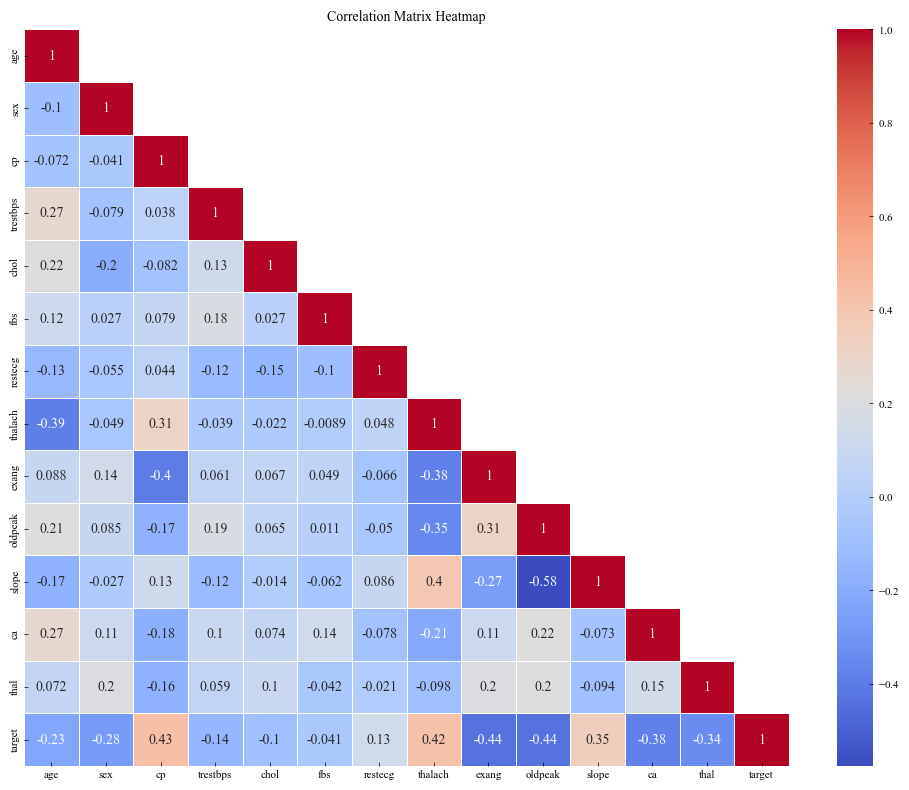

In [16]:
# Compute the correlation matrix
correlation_matrix = heart_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool),k=1)


# Set IEEE style parameters for the plot
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'legend.frameon': True,
    'legend.loc': 'best',
    'grid.color': 'k',
    'grid.alpha': 0.5,
    'axes.edgecolor': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.pad': 3,
    'ytick.major.pad': 3,
    'axes.labelpad': 4,
})

# Create the heatmap with the upper triangle masked
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()

# Save the plot as PNG with high DPI for better resolution
plt.savefig('ieee_correlation_matrix_heatmap.png', dpi=300)
plt.show()

In [17]:
# checking the distribution of target variable
heart_data['target'].value_counts()

target
1    526
0    499
Name: count, dtype: int64

### Data Visualization

<Axes: xlabel='target', ylabel='count'>

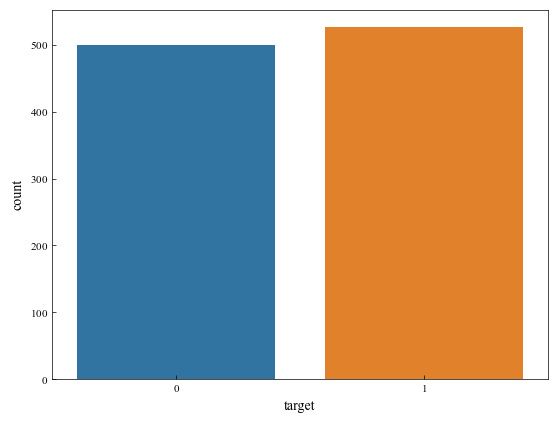

In [18]:
sns.countplot(x=heart_data["target"])

# distribution of target

here, we have approx equal distribution of data.

#### Notation for Healthy and Defective Heart

- 1 Represents a Defective Heart
- 0 Represents a Healthy Heart


#### Splitting the Features and Target

In [19]:
X = heart_data.drop(columns = 'target', axis = 1)
X.head()

# now X contains table without target column which will help for training the dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2


In [20]:
Y = heart_data['target']

# Y contains one column which includes output for validating the result after model prediction

#### Data Standardization

In [21]:
scaler = StandardScaler()

In [22]:
scaler.fit(X)
X_standard = scaler.transform(X)

In [23]:
X_standard

array([[-0.26843658,  0.66150409, -0.91575542, ...,  0.99543334,
         1.20922066,  1.08985168],
       [-0.15815703,  0.66150409, -0.91575542, ..., -2.24367514,
        -0.73197147,  1.08985168],
       [ 1.71659547,  0.66150409, -0.91575542, ..., -2.24367514,
        -0.73197147,  1.08985168],
       ...,
       [-0.81983438,  0.66150409, -0.91575542, ..., -0.6241209 ,
         0.23862459, -0.52212231],
       [-0.4889957 , -1.51170646, -0.91575542, ...,  0.99543334,
        -0.73197147, -0.52212231],
       [-0.04787747,  0.66150409, -0.91575542, ..., -0.6241209 ,
         0.23862459,  1.08985168]])

### Splitting the Data into Training data and Test data

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X_standard, Y, test_size = 0.20, stratify = Y, random_state = 0 )

# stratify will distribute 0 and 1 in even manner, of that prediction will be unbiased
# test_split tells a ratio about size of test data in dataset, means 20 percent of data is test data
# random_state tells about the randomness of data, and number tells about its extent of randomness

In [25]:
# checking shape of splitted data

print(X_standard.shape, X_train.shape, X_test.shape)

(1025, 13) (820, 13) (205, 13)


### Model Training


### 1. Logistic Regression



Model accuracy score: 0.8049
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       100
           1       0.82      0.80      0.81       105

    accuracy                           0.80       205
   macro avg       0.80      0.81      0.80       205
weighted avg       0.81      0.80      0.80       205



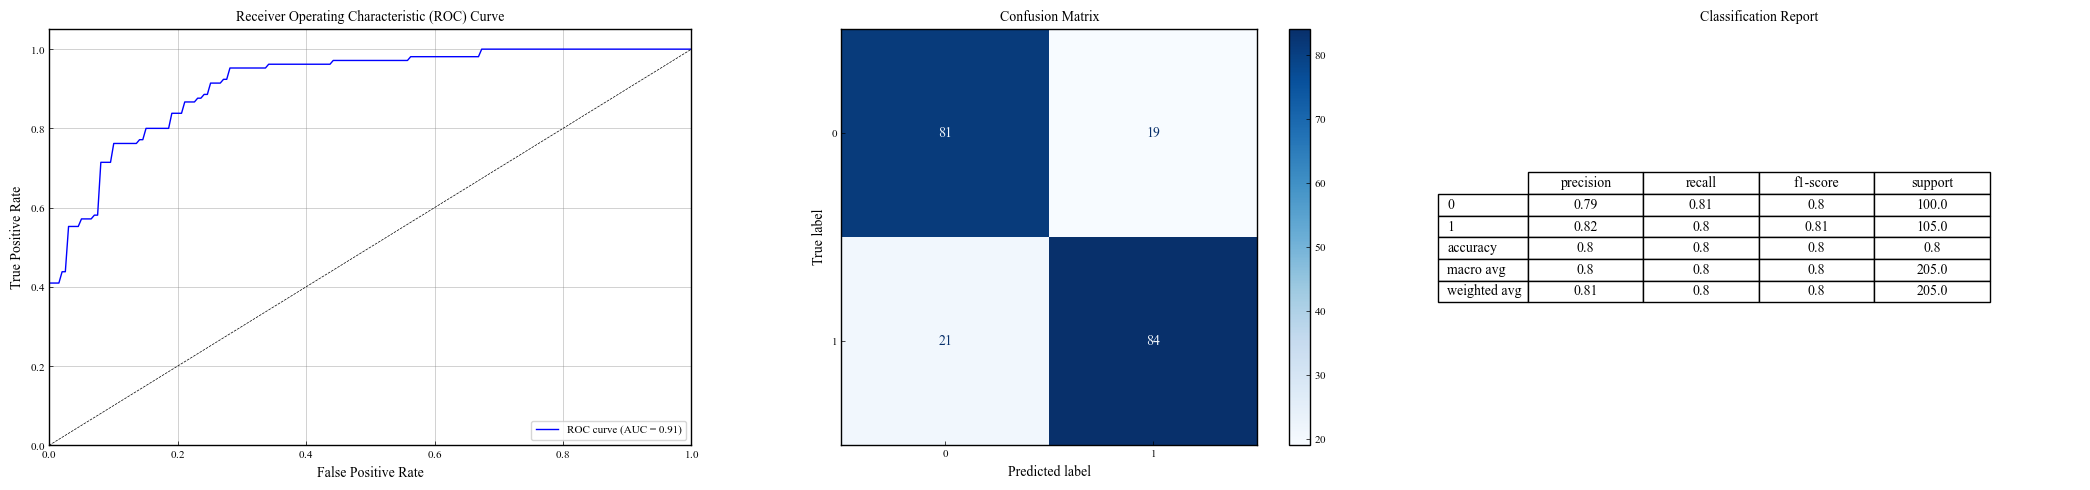

In [26]:
# instantiate the model
lr = LogisticRegression()

# training the LogisticRegression model with training data
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)

y_prob = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_prob)

# Compute AUC
auc = roc_auc_score(Y_test, y_prob)

# Interpolation for smoothing
fpr_new = np.linspace(0, 1, 200)
interp_func = interp1d(fpr, tpr, kind='linear')
tpr_smooth = interp_func(fpr_new)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Generate classification report
report = classification_report(Y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))
print (classification_report(Y_test, y_pred))

# Set IEEE style parameters
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'axes.linewidth': 1,
    'lines.linewidth': 1,
    'grid.linewidth': 0.5,
    'legend.frameon': True,
    'legend.loc': 'best',
    'grid.color': 'gray',  # Set grid color
    'grid.alpha': 0.5,     # Set grid transparency
    'axes.edgecolor': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.pad': 3,
    'ytick.major.pad': 3,
    'axes.labelpad': 4,
    'axes.formatter.use_mathtext': True
})

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 5))  # Adjust figure size as needed

# Plot ROC curve
axs[0].plot(fpr_new, tpr_smooth, label=f'ROC curve (AUC = {auc:.2f})', color='b')
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.5)
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(ax=axs[1], cmap='Blues', values_format='d')
axs[1].set_title('Confusion Matrix')
axs[1].grid(False)  # Disable grid for the confusion matrix

# Plot classification report as a table
axs[2].axis('off')  # Hide the axis
table = axs[2].table(cellText=report_df.values.round(2), colLabels=report_df.columns, rowLabels=report_df.index, loc='center', cellLoc='center', colWidths=[0.15]*len(report_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
axs[2].set_title('Classification Report')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('roc_and_classification_report.png', dpi=500)
plt.show()



### 2. Naive Bayes Classifier

In [27]:
# instantiate the model
gnb = GaussianNB()
# model = gnb

# fit the model
gnb.fit(X_train, Y_train)
y_pred = gnb.predict(X_test)

y_pred
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))
print (classification_report(Y_test, y_pred))

Model accuracy score: 0.8195
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       100
           1       0.83      0.82      0.82       105

    accuracy                           0.82       205
   macro avg       0.82      0.82      0.82       205
weighted avg       0.82      0.82      0.82       205



### 3. K-Nearest Neighbor (KNN)

In [28]:
# instantiate the model
knn = KNeighborsClassifier(n_neighbors=7)


# fit the model
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

y_pred
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))
print (classification_report(Y_test, y_pred))

Model accuracy score: 0.8390
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       100
           1       0.84      0.85      0.84       105

    accuracy                           0.84       205
   macro avg       0.84      0.84      0.84       205
weighted avg       0.84      0.84      0.84       205



### 4. Decision Tree Classifier

In [29]:
# Create Decision Tree classifer object
dtc = DecisionTreeClassifier(max_depth=3)


# fit the model
dtc.fit(X_train,Y_train)
y_pred = dtc.predict(X_test)

y_pred
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))
print (classification_report(Y_test, y_pred))

Model accuracy score: 0.8488
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       100
           1       0.86      0.85      0.85       105

    accuracy                           0.85       205
   macro avg       0.85      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205



### 5. Support Vector Machine 

In [30]:
# instantiate the model
svm = SVC(probability=True) 

# fitting x samples and y classes
svm.fit(X_train, Y_train)
y_pred = svm.predict(X_test)

y_pred
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))
print (classification_report(Y_test, y_pred))

Model accuracy score: 0.8829
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       100
           1       0.86      0.91      0.89       105

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205



## Multi-model training

Majority Voting Ensemble Predicted Value: [0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0
 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1
 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1
 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0
 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0
 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0]
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       100
           1       0.87      0.89      0.88       105

    accuracy                           0.87       205
   macro avg       0.87      0.87      0.87       205
weighted avg       0.87      0.87      0.87       205

[[86 14]
 [12 93]]
Model accuracy score: 0.8732
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       100
           1       0.87      0.89      0.88       105

  

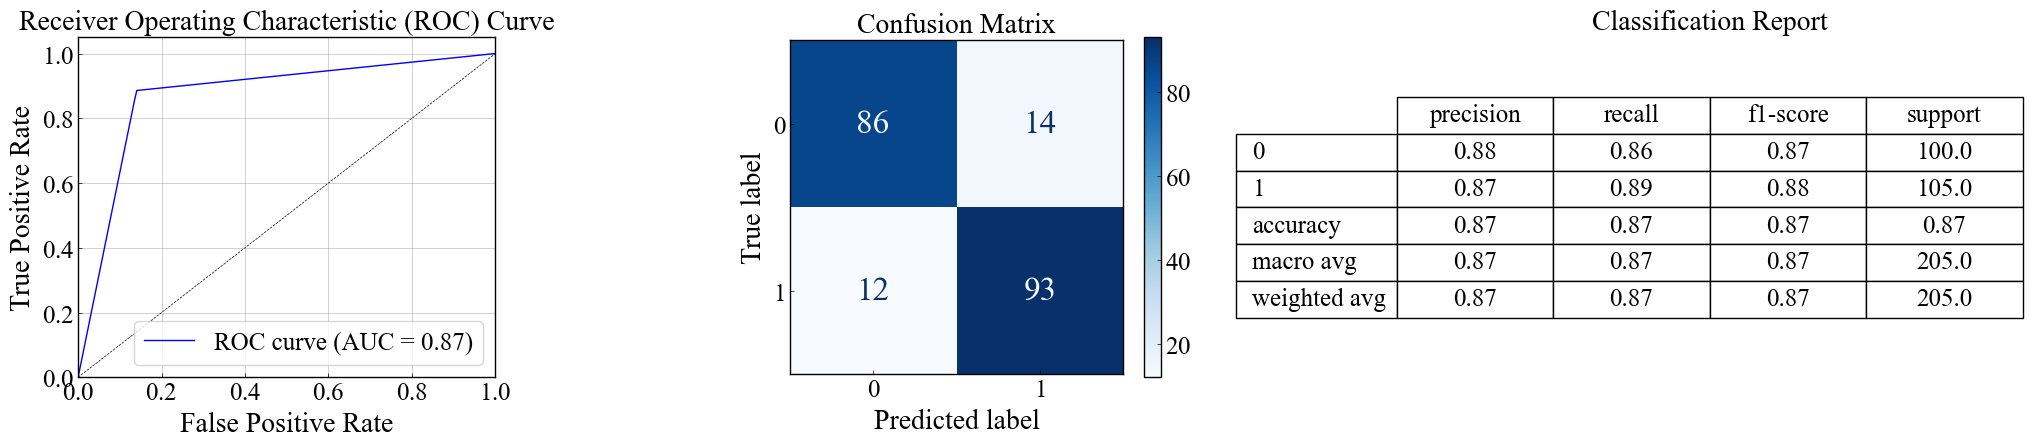

In [31]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
estimators=[('KNN', knn), ('CART', dtc), ('SVM', svm), ('Gaussian NB', gnb), ('Logistic Regression', lr)],
voting='soft')
voting_clf.fit(X_train, Y_train)
# Predict probabilities and labels for the test data
y_prob = voting_clf.predict_proba(X_test)[:, 1]
Voting_pred = voting_clf.predict(X_test)


print("Majority Voting Ensemble Predicted Value:", Voting_pred)
print (classification_report(Y_test, Voting_pred))
print(confusion_matrix(Y_test, Voting_pred))
cross_val_score(voting_clf, X_standard, Y, cv=20, scoring="accuracy")


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Voting_pred)

# Compute AUC
auc = roc_auc_score(Y_test, Voting_pred)

# Interpolation for smoothing
fpr_new = np.linspace(0, 1, 200)
interp_func = interp1d(fpr, tpr, kind='linear')
tpr_smooth = interp_func(fpr_new)

# Compute confusion matrix
cm = confusion_matrix(Y_test, Voting_pred)

report = classification_report(Y_test, Voting_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, Voting_pred)))
print (classification_report(Y_test, Voting_pred))

# Set IEEE style parameters
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'font.size': 24,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'axes.linewidth': 1,
    'lines.linewidth': 1,
    'grid.linewidth': 0.5,
    'legend.frameon': True,
    'legend.loc': 'best',
    'grid.color': 'gray',  # Set grid color
    'grid.alpha': 0.5,     # Set grid transparency
    'axes.edgecolor': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.pad': 3,
    'ytick.major.pad': 3,
    'axes.labelpad': 4,
    'axes.formatter.use_mathtext': True
})

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 5))  # Adjust figure size as needed

# Plot ROC curve
axs[0].plot(fpr_new, tpr_smooth, label=f'ROC curve (AUC = {auc:.2f})', color='b')
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.5)
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(ax=axs[1], cmap='Blues', values_format='d')
axs[1].set_title('Confusion Matrix')
axs[1].grid(False)  # Disable grid for the confusion matrix

# Plot classification report as a table
axs[2].axis('off')  # Hide the axis
table = axs[2].table(cellText=report_df.values.round(2), colLabels=report_df.columns, rowLabels=report_df.index, loc='center', cellLoc='center', colWidths=[0.15]*len(report_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(2.5, 2.5)
axs[2].set_title('Classification Report')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('roc_and_classification_report.png', dpi=500)
plt.show()









In [32]:
abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)
bc = BaggingClassifier(n_estimators = 50, random_state = 2)
gbdt = GradientBoostingClassifier(n_estimators = 50, random_state = 2)

In [33]:
classification = {
    'AdaBoost Classifier': abc,
    'Bagging Classifier' : bc,
    'Gradient Boosting Classifier' : gbdt
}

In [34]:
def train_classifier(classification, X_train, y_train, X_test, y_test):
  classification.fit(X_train, y_train)
  y_pred = classification.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1score = f1_score(y_test, y_pred)
  matrix = confusion_matrix(y_test, y_pred)

  return accuracy, precision,recall,f1score, matrix

In [35]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, cls in classification.items():
  curr_accuracy, curr_precision,curr_recall,curr_f1score, matrix = train_classifier(cls, X_train, Y_train, X_test, Y_test)
  print("Model name : ", name)
  print("Accuracy : ", curr_accuracy)
  print("Precision : ", curr_precision)
  print("Recall : ", curr_recall)
  print("F1 Score : ", curr_f1score)
  print("Confusin-Matrix : ", '\n', matrix, '\n')

  accuracy_scores.append(curr_accuracy)
  precision_scores.append(curr_precision)
  recall_scores.append(curr_recall)
  f1_scores.append(curr_f1score)




Model name :  AdaBoost Classifier
Accuracy :  0.9024390243902439
Precision :  0.9047619047619048
Recall :  0.9047619047619048
F1 Score :  0.9047619047619048
Confusin-Matrix :  
 [[90 10]
 [10 95]] 

Model name :  Bagging Classifier
Accuracy :  0.9853658536585366
Precision :  1.0
Recall :  0.9714285714285714
F1 Score :  0.9855072463768115
Confusin-Matrix :  
 [[100   0]
 [  3 102]] 

Model name :  Gradient Boosting Classifier
Accuracy :  0.9219512195121952
Precision :  0.9158878504672897
Recall :  0.9333333333333333
F1 Score :  0.9245283018867924
Confusin-Matrix :  
 [[91  9]
 [ 7 98]] 



In [36]:
result_dataframe = pd.DataFrame({'Algorithm': classification.keys(), 'Accuracy': accuracy_scores, 'Precision' : precision_scores, 'Recall' : recall_scores, 'F1 Score' : f1_scores}).sort_values('Accuracy', ascending =True)

In [37]:
result_dataframe

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,AdaBoost Classifier,0.902439,0.904762,0.904762,0.904762
2,Gradient Boosting Classifier,0.921951,0.915888,0.933333,0.924528
1,Bagging Classifier,0.985366,1.000000,0.971429,0.985507


### Model Improvement

In [38]:
# voting classifier :  ensemble learning method that combines the predictions of several different machine learning models to produce a final prediction.
# The models that are combined can be of different types, such as decision trees, support vector machines, or random forests.


abc = AdaBoostClassifier(n_estimators = 50, random_state = 2)
bc = BaggingClassifier(n_estimators = 50, random_state = 2)
gbdt = GradientBoostingClassifier(n_estimators = 50, random_state = 2)


In [39]:
improved_voting_clf = VotingClassifier(estimators=[('abc', abc), ('bc', bc), ('gbdt', gbdt)],voting='soft')

In [40]:
improved_voting_clf.fit(X_train, Y_train)

VotingClassifier(estimators=[('abc', AdaBoostClassifier(random_state=2)),
                             ('bc',
                              BaggingClassifier(n_estimators=50,
                                                random_state=2)),
                             ('gbdt',
                              GradientBoostingClassifier(n_estimators=50,
                                                         random_state=2))],
                 voting='soft')

0.9902439024390244
[[100   0]
 [  2 103]]
Precision Score:  1.0
F1 Score:  0.9903846153846153
Recall Score:  0.9809523809523809
Model accuracy score: 0.9902
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       1.00      0.98      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



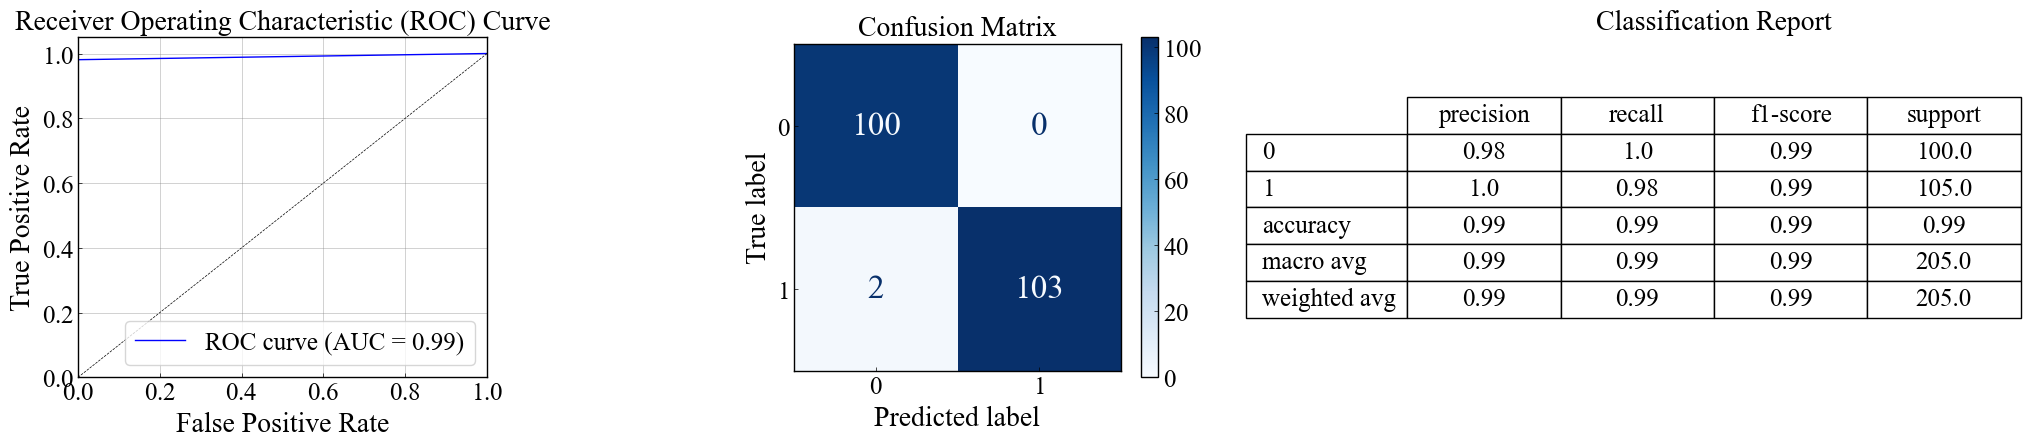

array([1.        , 1.        , 1.        , 1.        , 0.97087379,
       1.        , 1.        , 1.        , 0.97058824, 0.96078431])

In [41]:
improved_y_pred = improved_voting_clf.predict(X_test)

print(accuracy_score(Y_test, improved_y_pred))
print(confusion_matrix(Y_test, improved_y_pred))
print("Precision Score: ",precision_score(Y_test, improved_y_pred))
print("F1 Score: ",f1_score(Y_test, improved_y_pred))
print("Recall Score: ",recall_score(Y_test, improved_y_pred))
# voting model is most accurate and precise

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, improved_y_pred)

# Compute AUC
auc = roc_auc_score(Y_test, improved_y_pred)

# Interpolation for smoothing
fpr_new = np.linspace(0, 1, 200)
interp_func = interp1d(fpr, tpr, kind='linear')
tpr_smooth = interp_func(fpr_new)

# Compute confusion matrix
cm = confusion_matrix(Y_test, improved_y_pred)

report = classification_report(Y_test, improved_y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, improved_y_pred)))
print (classification_report(Y_test, improved_y_pred))

# Set IEEE style parameters
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'font.size': 24,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'axes.linewidth': 1,
    'lines.linewidth': 1,
    'grid.linewidth': 0.5,
    'legend.frameon': True,
    'legend.loc': 'best',
    'grid.color': 'gray',  # Set grid color
    'grid.alpha': 0.5,     # Set grid transparency
    'axes.edgecolor': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.pad': 3,
    'ytick.major.pad': 3,
    'axes.labelpad': 4,
    'axes.formatter.use_mathtext': True
})

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 5))  # Adjust figure size as needed

# Plot ROC curve
axs[0].plot(fpr_new, tpr_smooth, label=f'ROC curve (AUC = {auc:.2f})', color='b')
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.5)
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(ax=axs[1], cmap='Blues', values_format='d')
axs[1].set_title('Confusion Matrix')
axs[1].grid(False)  # Disable grid for the confusion matrix

# Plot classification report as a table
axs[2].axis('off')  # Hide the axis
table = axs[2].table(cellText=report_df.values.round(2), colLabels=report_df.columns, rowLabels=report_df.index, loc='center', cellLoc='center', colWidths=[0.15]*len(report_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(2.5, 2.5)
axs[2].set_title('Classification Report')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('improved_roc_and_classification_report.png', dpi=500)
plt.show()

# 10 folds cross validation
cross_val_score(improved_voting_clf, X_standard, Y, cv=10, scoring="accuracy")

In [42]:
voting_VCs = VotingClassifier(
estimators=[('VC1', voting_clf), ('VC2', improved_voting_clf)],
voting='hard')

In [43]:
voting_VCs.fit(X_train, Y_train)

VotingClassifier(estimators=[('VC1',
                              VotingClassifier(estimators=[('KNN',
                                                            KNeighborsClassifier(n_neighbors=7)),
                                                           ('CART',
                                                            DecisionTreeClassifier(max_depth=3)),
                                                           ('SVM',
                                                            SVC(probability=True)),
                                                           ('Gaussian NB',
                                                            GaussianNB()),
                                                           ('Logistic '
                                                            'Regression',
                                                            LogisticRegression())],
                                               voting='soft')),
                             ('VC2',
                              VotingClassifier(estimators=[('abc',
                                                            AdaBoostClassifier(random_state=2)),
                                                           ('bc',
                                                            BaggingClassifier(n_estimators=50,
                                                                              random_state=2)),
                                                           ('gbdt',
                                                            GradientBoostingClassifier(n_estimators=50,
                                                                                       random_state=2))],
                                               voting='soft'))])

In [44]:
VCs_y_pred = voting_VCs.predict(X_test)

0.9414634146341463
[[100   0]
 [ 12  93]]
Precision Score:  1.0
F1 Score:  0.9393939393939393
Recall Score:  0.8857142857142857
Model accuracy score: 0.9415
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       100
           1       1.00      0.89      0.94       105

    accuracy                           0.94       205
   macro avg       0.95      0.94      0.94       205
weighted avg       0.95      0.94      0.94       205



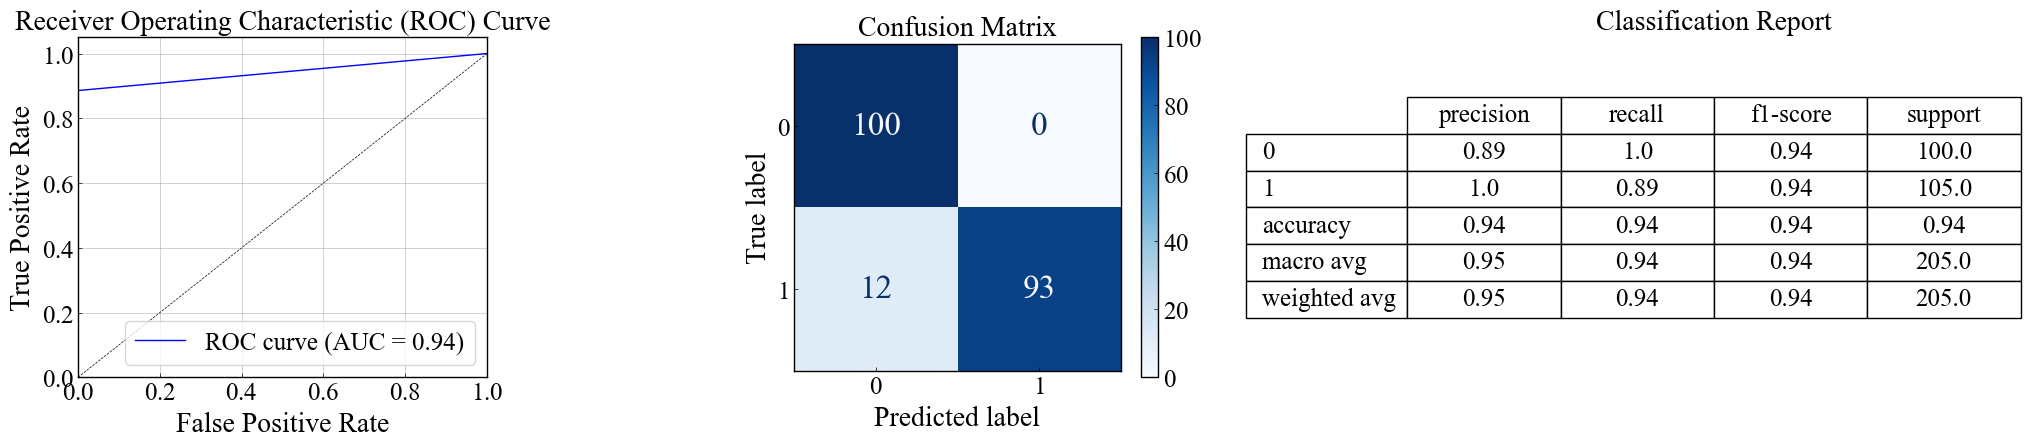

array([0.97087379, 0.97087379, 0.97087379, 0.97087379, 0.94174757,
       0.97058824, 0.97058824, 0.94117647, 0.91176471, 0.91176471])

In [45]:
print(accuracy_score(Y_test, VCs_y_pred))
print(confusion_matrix(Y_test, VCs_y_pred))
print("Precision Score: ",precision_score(Y_test, VCs_y_pred))
print("F1 Score: ",f1_score(Y_test, VCs_y_pred))
print("Recall Score: ",recall_score(Y_test, VCs_y_pred))
# voting model is most accurate and precise

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, VCs_y_pred)

# Compute AUC
auc = roc_auc_score(Y_test, VCs_y_pred)

# Interpolation for smoothing
fpr_new = np.linspace(0, 1, 200)
interp_func = interp1d(fpr, tpr, kind='linear')
tpr_smooth = interp_func(fpr_new)

# Compute confusion matrix
cm = confusion_matrix(Y_test, VCs_y_pred)

report = classification_report(Y_test, VCs_y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(Y_test, VCs_y_pred)))
print (classification_report(Y_test, VCs_y_pred))

# Set IEEE style parameters
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': False,
    'font.size': 24,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'axes.linewidth': 1,
    'lines.linewidth': 1,
    'grid.linewidth': 0.5,
    'legend.frameon': True,
    'legend.loc': 'best',
    'grid.color': 'gray',  # Set grid color
    'grid.alpha': 0.5,     # Set grid transparency
    'axes.edgecolor': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k',
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.pad': 3,
    'ytick.major.pad': 3,
    'axes.labelpad': 4,
    'axes.formatter.use_mathtext': True
})

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 5))  # Adjust figure size as needed

# Plot ROC curve
axs[0].plot(fpr_new, tpr_smooth, label=f'ROC curve (AUC = {auc:.2f})', color='b')
axs[0].plot([0, 1], [0, 1], 'k--', lw=0.5)
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(ax=axs[1], cmap='Blues', values_format='d')
axs[1].set_title('Confusion Matrix')
axs[1].grid(False)  # Disable grid for the confusion matrix

# Plot classification report as a table
axs[2].axis('off')  # Hide the axis
table = axs[2].table(cellText=report_df.values.round(2), colLabels=report_df.columns, rowLabels=report_df.index, loc='center', cellLoc='center', colWidths=[0.15]*len(report_df.columns))
table.auto_set_font_size(False)
table.set_fontsize(18)
table.scale(2.5, 2.5)
axs[2].set_title('Classification Report')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('VC_roc_and_classification_report.png', dpi=500)
plt.show()

# 10 folds cross validation
cross_val_score(voting_VCs, X_standard, Y, cv=10, scoring="accuracy")

## Comparison with other implemented classifiers

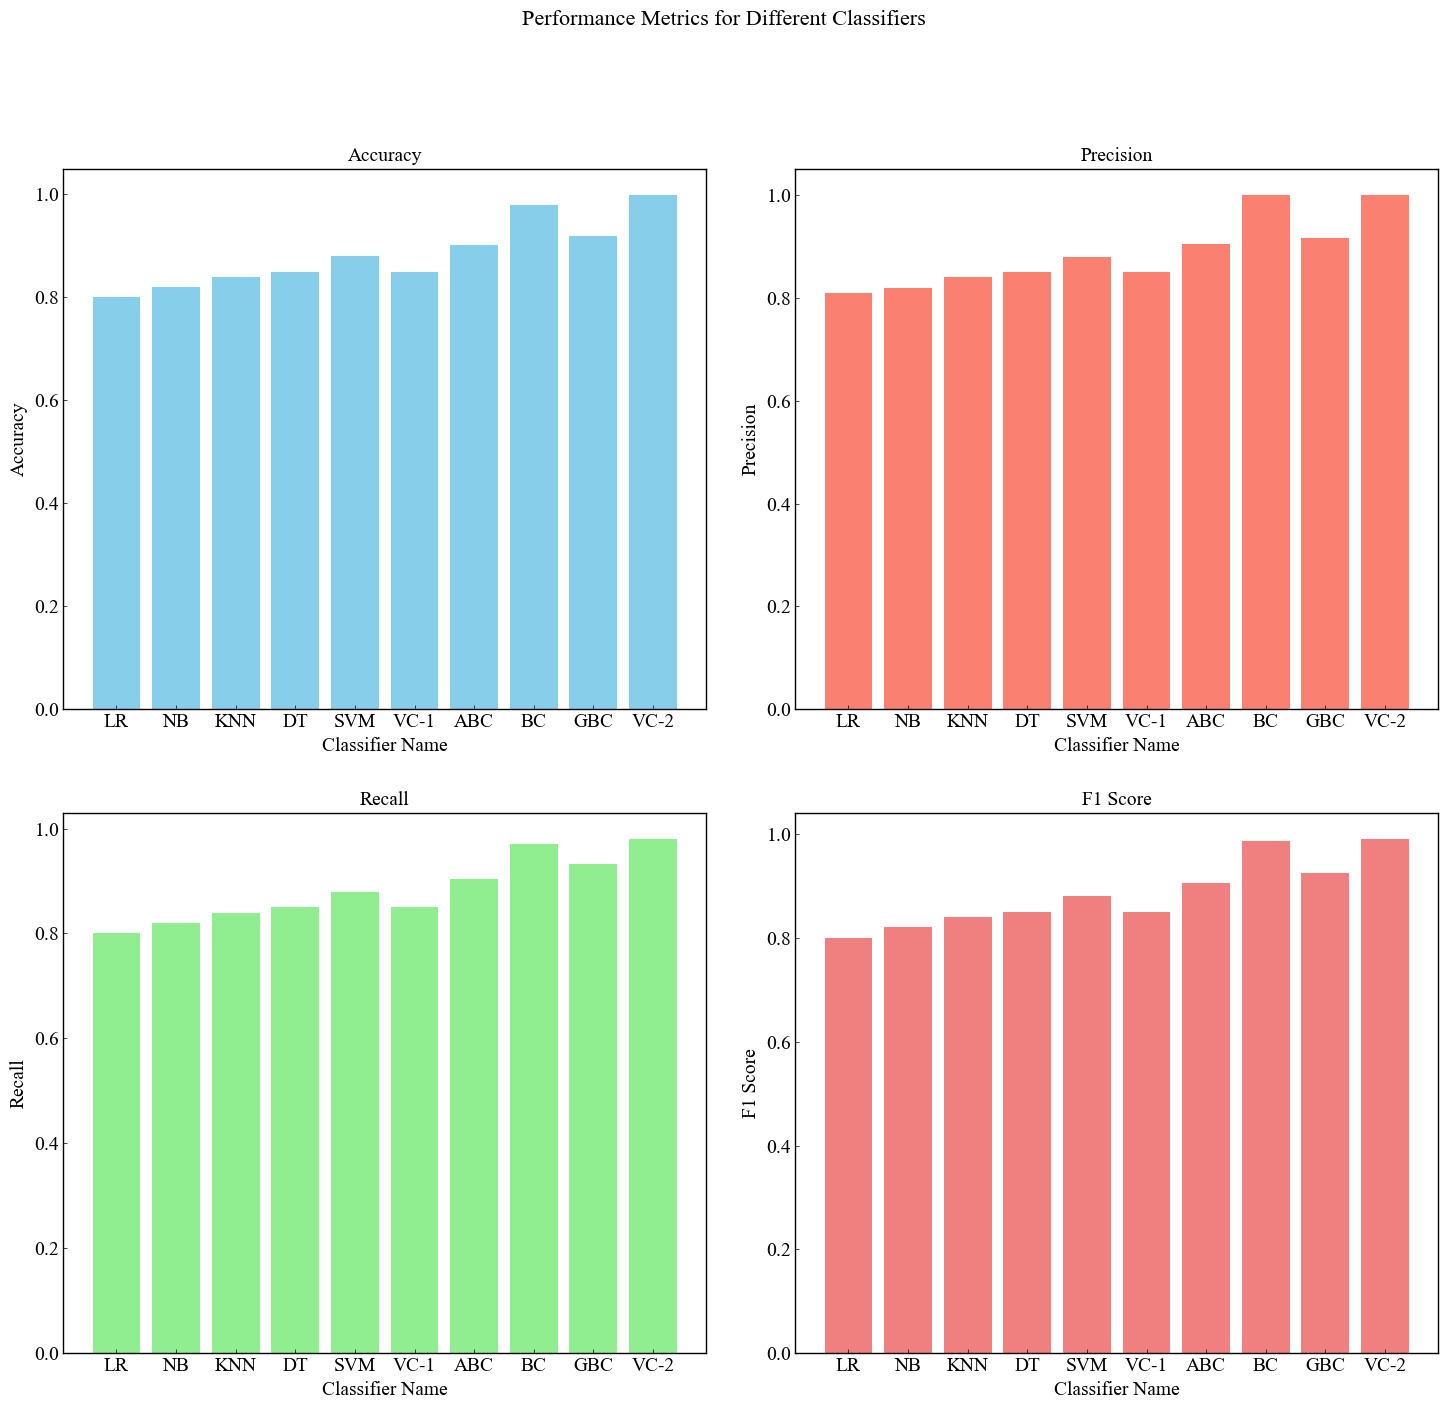

In [46]:
data = {
    
    'Classifier Name': ['LR','NB','KNN','DT','SVM','VC-1','ABC','BC','GBC','VC-2'],
    'Accuracy': [0.80, 0.8195, 0.8390, 0.85, 0.88, 0.85, 0.9024, 0.98, 0.92, 0.9987],
    'Precision': [0.81, 0.82, 0.84, 0.85, 0.88, 0.85, 0.9047, 1, 0.9158, 1],
    'Recall': [0.80, 0.82, 0.84, 0.85, 0.88, 0.85, 0.9047, 0.9714, 0.9333, 0.98],
    'F1 Score': [0.80, 0.82, 0.84, 0.85, 0.88, 0.85, 0.9047, 0.9855, 0.9247, 0.99]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Increase font size
font_size = 14

# Plotting all metrics in one figure
plt.figure(figsize=(15, 15))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.bar(df['Classifier Name'], df['Accuracy'], color='skyblue')
plt.title('Accuracy', fontsize=font_size)
plt.xlabel('Classifier Name', fontsize=font_size)
plt.ylabel('Accuracy', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Plot precision
plt.subplot(2, 2, 2)
plt.bar(df['Classifier Name'], df['Precision'], color='salmon')
plt.title('Precision', fontsize=font_size)
plt.xlabel('Classifier Name', fontsize=font_size)
plt.ylabel('Precision', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Plot recall
plt.subplot(2, 2, 3)
plt.bar(df['Classifier Name'], df['Recall'], color='lightgreen')
plt.title('Recall', fontsize=font_size)
plt.xlabel('Classifier Name', fontsize=font_size)
plt.ylabel('Recall', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Plot F1 score
plt.subplot(2, 2, 4)
plt.bar(df['Classifier Name'], df['F1 Score'], color='lightcoral')
plt.title('F1 Score', fontsize=font_size)
plt.xlabel('Classifier Name', fontsize=font_size)
plt.ylabel('F1 Score', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Overall title
plt.suptitle('Performance Metrics for Different Classifiers', fontsize=font_size + 2)
# Save the figure as a PNG file
plt.savefig('performance_metrics.png')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Model Evaluation

- Accuracy score
  - 1. For training data
  - 2. For testing data

  accuracy score for both should be closer to 1

- Other Metrices:
  - 1. Accuracy
  - 2. Precision
  - 3. Recall
  - 4. F1 Score

- Confusion Metrix
  

In [47]:
# accuracy of traning data
# accuracy function measures accuracy between two values,or columns

X_train_prediction = voting.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

print("The accuracy of training data : ", training_data_accuracy)


NameError: name 'voting' is not defined

In [ ]:
# accuracy of traning data
# accuracy function measures accuracy between two values,or columns

X_train_prediction = voting.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

print("The accuracy of training data : ", training_data_accuracy)


In [ ]:
# Accuracy, F1, Recall, Precision

Y_pred = voting.predict(X_test)


accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy   :", accuracy)
precision = precision_score(Y_test, Y_pred)
print("Precision  :", precision)
recall = recall_score(Y_test, Y_pred)
print("Recall     :", recall)
F1_score = f1_score(Y_test, Y_pred)
print("F1-score   :", F1_score)

In [ ]:
# confusion matrix

cm = confusion_matrix(Y_test,Y_pred)

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Detected', 'Not Detected'],
            yticklabels=['Detected', 'Not Detected'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

## Building Prediction system

#### Steps :

  - take input data
  - Process the data, change into array
  - reshape data as single element in array
  - predict output using predict function
  - output the value

In [ ]:
# input feature values
input_data = (58,0,3,150,283,1,0,162,0,1,2,0,2)

# changing data to numpy array
input_data_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped =  input_data_array.reshape(1,-1)

# standarize the input data
# std_data = scaler.transform(input_data_reshaped)
# print(std_data[0])


In [ ]:
# predicting the result and printing it

prediction = voting.predict(input_data_reshaped)

print(prediction)

if(prediction[0] == 0):
    print("Patient has a healthy heart")

else:
    print("Patient has a heart Disease")

### Notations
  - [0] : means patient has a healthy heart 
  - [1] : means patient has a unhealthy heart 
  

## Saving the model

In [ ]:
import pickle
# importing the library

filename = "trained_model.pkl"
pickle.dump(voting, open(filename, 'wb'))
# saving file


In [ ]:
# loading the saved model

loaded_model = pickle.load(open("trained_model.pkl",'rb'))

In [ ]:
# save the model to disk
filename = 'heart_model.sav'
joblib.dump(voting, filename)